<a href="https://colab.research.google.com/github/nandir2512/NLP/blob/main/Sentiment_Analysis_Using_Bag_of_Words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk, random
from nltk.corpus import movie_reviews
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

# Data Loading

We will use the corpus nlkt.corpus.movie_reviews as our data.

In [2]:
nltk.download('movie_reviews')
print(len(movie_reviews.fileids()))
print(movie_reviews.categories())
print(movie_reviews.words()[:100])
print(movie_reviews.fileids()[:10])

2000
['neg', 'pos']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]
['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt']


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


Rearrange the corpus data as a list of tuple, where the first element is the word tokens of the documents, and the second element is the label of the documents (i.e., sentiment labels).

In [3]:
documents = [(list(movie_reviews.words(fileid)), category)
              for category in movie_reviews.categories()
              for fileid in movie_reviews.fileids(category)]
random.seed(123)
random.shuffle(documents)


In [4]:
print('Number of Reviews/Documents:{}'.format(len(documents)))
print('Corpus Size (words):{}'.format(np.sum([len(d) for (d,l) in documents])))
print('Sample Text of Doc 1:')
print('-'*30)
print(' '.join(documents[0][0][:50])) # first 50 words of the first document

Number of Reviews/Documents:2000
Corpus Size (words):1583820
Sample Text of Doc 1:
------------------------------
most movies seem to release a third movie just so it can be called a trilogy . rocky iii seems to kind of fit in that category , but manages to be slightly unique . the rocky formula of " rocky loses fight / rocky trains / rocky wins fight


In [5]:
#Check Sentiment Distribution of the current Dataset
from collections import Counter
sentiment_distr = Counter([label for (words, label) in documents])
print(sentiment_distr)

Counter({'pos': 1000, 'neg': 1000})


 # Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(documents, test_size=0.33, random_state=42 )

In [7]:
# Sentiment Distribution for Train And Test
print(Counter([label for (words, label) in train]))
print(Counter([label for (words, label) in test]))


Counter({'neg': 674, 'pos': 666})
Counter({'pos': 334, 'neg': 326})


In [8]:
X_train = [' '.join(words) for (words, label) in train]
X_test = [' '.join(words) for (words, label) in test]
y_train = [label for (words, label) in train]
y_test = [label for (words, label) in test]

# Text Vectorization

* Always split the data into train and test first before vectorizing the texts
* Otherwise, you would leak information to the training process, which may lead to over-fitting
* When vectorizing the texts, fit_transform() on the training set and transform() on the testing set.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df = 10, token_pattern = r'[a-zA-Z]+', stop_words= 'english')
X_train_bow = tfidf_vec.fit_transform(X_train)
X_test_bow = tfidf_vec.transform(X_test)

In [10]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(1340, 5857)
(660, 5857)


# Model Selection and Cross Validation
* For our current binary sentiment classifier, we will try a few common classification algorithms:
  * Support Vector Machine
  * Decision Tree
  * Naive Bayes
  * Logistic Regression

* The common steps include:
  * We fit the model with our training data.
  * We check the model stability, using k-fold cross validation on the training data.
  * We use the fitted model to make prediction.
  * We evaluate the model prediction by comparing the predicted classes and the true labels.

#SVM

In [11]:
from sklearn import svm

model_svm = svm.SVC(C=0.8, kernel='linear')
model_svm.fit(X_train_bow, y_train)

SVC(C=0.8, kernel='linear')

In [12]:
from sklearn.model_selection import cross_val_score
model_svm_acc = cross_val_score(estimator=model_svm, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_svm_acc


array([0.82462687, 0.80597015, 0.84701493, 0.81716418, 0.82835821])

In [13]:
model_svm.predict(X_test_bow[:10])


array(['pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'pos'], dtype='<U3')

In [14]:
print(model_svm.score(X_test_bow, y_test))

0.8166666666666667


# Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

model_dec = DecisionTreeClassifier(max_depth=10, random_state=0)
model_dec.fit(X_train_bow, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [16]:
model_dec_acc = cross_val_score(estimator=model_dec, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_dec_acc

array([0.65298507, 0.67164179, 0.73134328, 0.6380597 , 0.6380597 ])

In [17]:
model_dec.predict(X_test_bow[:10])

array(['pos', 'neg', 'neg', 'neg', 'neg', 'pos', 'neg', 'pos', 'neg',
       'neg'], dtype='<U3')

# Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train_bow.toarray(), y_train)

GaussianNB()

In [19]:
model_gnb_acc = cross_val_score(estimator=model_gnb, X=X_train_bow.toarray(), y=y_train, cv=5, n_jobs=-1)
model_gnb_acc

array([0.7238806 , 0.66791045, 0.7238806 , 0.67910448, 0.68656716])

In [20]:
model_gnb.predict(X_test_bow[:10].toarray())

array(['pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'neg'], dtype='<U3')

# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

model_lg = LogisticRegression()
model_lg.fit(X_train_bow, y_train)

LogisticRegression()

In [22]:
model_lg_acc = cross_val_score(estimator=model_lg, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
model_lg_acc

array([0.83208955, 0.78358209, 0.84328358, 0.79850746, 0.80970149])

In [23]:
model_lg.predict(X_test_bow[:10].toarray())

array(['pos', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg',
       'pos'], dtype='<U3')

# Evaluation

In [24]:
#Mean Accuracy
print("SVM:", model_svm.score(X_test_bow, y_test))
print("Decision:",model_dec.score(X_test_bow, y_test))
print("Naive Bayes:",model_gnb.score(X_test_bow.toarray(), y_test))
print("Logistic:",model_lg.score(X_test_bow, y_test))

SVM: 0.8166666666666667
Decision: 0.6651515151515152
Naive Bayes: 0.7121212121212122
Logistic: 0.8136363636363636


In [25]:
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, precision_score, recall_score

In [26]:
# F1 Score

y_pred = model_svm.predict(X_test_bow)
f1_score(y_test, y_pred, average=None, labels= movie_reviews.categories())


array([0.80824089, 0.82438316])

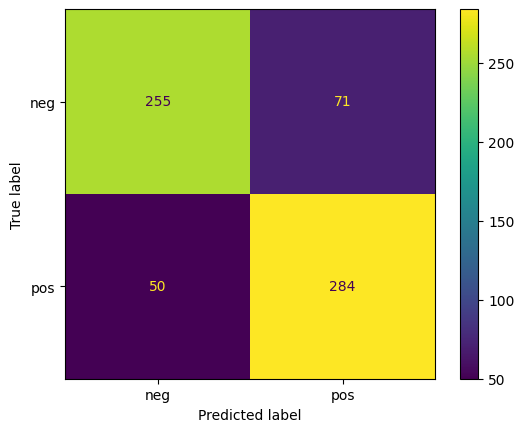

In [27]:
ConfusionMatrixDisplay.from_estimator(model_svm, X_test_bow, y_test )

In [28]:
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))

[0.83606557 0.8       ]
[0.78220859 0.8502994 ]


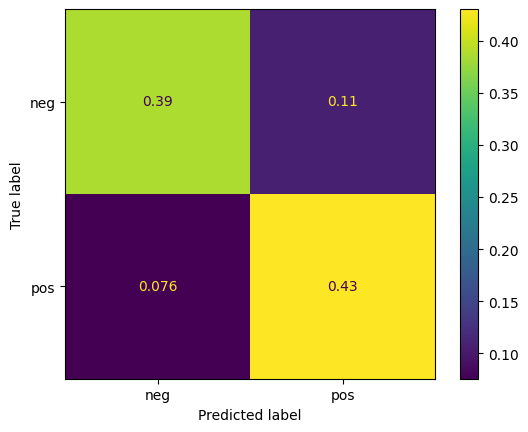

In [29]:
ConfusionMatrixDisplay.from_estimator(model_svm, X_test_bow, y_test, normalize='all' )

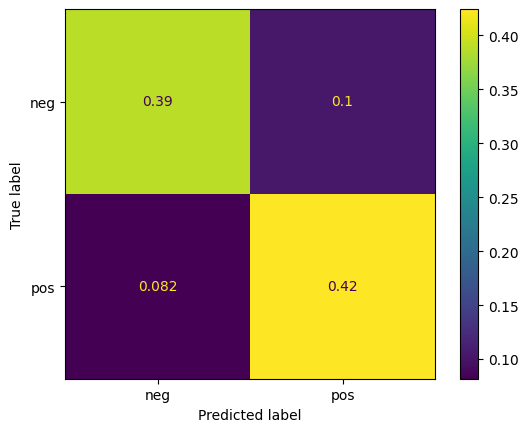

In [30]:
#Logistic Reg
ConfusionMatrixDisplay.from_estimator(model_lg, X_test_bow.toarray(), y_test, normalize='all')

In [31]:
y_pred = model_lg.predict(X_test_bow)
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))

[0.82636656 0.80229226]
[0.78834356 0.83832335]


In [32]:
## try a whole new self-created review:)
new_review =['This book looks so like the content but the cover is weird',
             'This book looks not good like the content and the cover is weird',
             "This movie's characters are good",
            ]
new_review_bow = tfidf_vec.transform(new_review)
model_svm.predict(new_review_bow)

array(['neg', 'neg', 'neg'], dtype='<U3')

# Tuning Model Hyperparameters - Grid Search

* For each model, we have not optimized it in terms of its hyperparameter setting.
* Now that SVM seems to perform the best among all, we take this as our base model and further fine-tune its hyperparameter using cross-validation and Grid Search.

In [33]:
from sklearn.model_selection import GridSearchCV


In [34]:
parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5, n_jobs=-1)
clf.fit(X_train_bow, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': (1, 4, 8), 'kernel': ('linear', 'rbf')})

In [35]:
print(sorted(clf.cv_results_.keys()))

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


In [36]:
print(clf.best_params_)

{'C': 1, 'kernel': 'linear'}


In [37]:
print(clf.score(X_test_bow, y_test))

0.8212121212121212


# Post-hoc Analysis
* After we find the optimal classifier, next comes the most important step: interpret the classifier.
* A good classifier may not always perform as we have expected. Chances are that the classifier may have used cues that are unexpected for decision making.
* In the post-hoc analysis, we are interested in:
  * Which features contribute to the classifier’s prediction the most?
  * Which features are more relevant to each class prediction?
* We will introduce three methods for post-hoc analysis:

  * LIME
  *  Model coefficients and feature importance
  * Permutation importances

# **LIME**
* Using LIME (Local Interpretable Model-agnostic Explanations) to interpret the **importance of the features** in relation to the model prediction.
* LIME was introduced in 2016 by Marco Ribeiro and his collaborators in a paper called “Why Should I Trust You?” Explaining the Predictions of Any Classifier
*  Its objective is to explain a model prediction for a specific text sample in a human-interpretable way.
* What we have done so far tells us that the model accuracy is good, but we have no idea **whether the classifier has learned features that are useful and meaningful**.
* How can we identify important words that may have great contribution to the model prediction?

In [38]:
!pip install lime
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import Pipeline

In [39]:
# Refit model based on optimal parameter settings
pipeline = Pipeline([
    ('vectorizer', tfidf_vec),
    ('clf', svm.SVC(C=4, kernel='rbf', probability=True))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=10, stop_words='english',
                                 token_pattern='[a-zA-Z]+')),
                ('clf', SVC(C=4, probability=True))])

In [40]:
import textwrap
reviews_test =X_test
sentiments_test = y_test

#We choose a sample from test set
idx=210
text_sample = reviews_test[idx]
class_name= ['negative', 'positive']

print('Review ID-{}:'.format(idx))
print('-'*50)
print('Review Text:\n', textwrap.fill(text_sample, 400))
print('Probability(posotive)=', pipeline.predict_proba([text_sample])[0,1])
print('Probability(negative)=', pipeline.predict_proba([text_sample])[0,0])
print('Predicted class: %s' % pipeline.predict([text_sample]))
print('True class: %s' % sentiments_test[idx])

Review ID-210:
--------------------------------------------------
Review Text:
 in ` enemy at the gates ' , jude law is a gifted russian sniper made hero by a political officer named danilov ( joseph fiennes ) who uses him in a propaganda newspaper to raise the hopes of the soldiers and people of stalingrad . it ' s world war ii , and the russian - german standoff in town could determine the outcome of things for the motherland . law ' s vassili is the russian ' s top pawn to
victory . lots of war stuff happens . an older , german version of jude ' s character played by ed harris shows up halfway into the proceedings . he ' s equally talented , and the two men play a cat and mouse game trying to kill each other . they constantly switch roles , as the war fades far into the background . the cast also includes the terrific rachel weisz as a love interest for both vassili
and danilov the set - up is decent , and so are the production values . boasting a wide range of grimy locales , greas

In [41]:
import matplotlib
matplotlib.rcParams['figure.dpi']=300
%matplotlib inline

In [42]:
explainer = LimeTextExplainer(class_names=class_name)
explanation = explainer.explain_instance(text_sample,
                                         pipeline.predict_proba,
                                         num_features=20)
explanation.show_in_notebook(text=True)

# Model Coefficients and Feature Importance
* Another way to evaluate the importance of the features is to look at their corresponding coefficients.
* Positive weights imply positive contribution of the feature to the prediction; negative weights imply negative contribution of the feature to the prediction.
* The absolute values of the weights indicate the effect sizes of the features.

Not all ML models provide “coefficients”. So used linear kernel

In [43]:
# Refit model based on optimal parameter settings
pipeline = Pipeline([
    ('vectorizer', tfidf_vec),
    ('clf', svm.SVC(C=1, kernel='linear', probability=True))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=10, stop_words='english',
                                 token_pattern='[a-zA-Z]+')),
                ('clf', SVC(C=1, kernel='linear', probability=True))])

In [44]:
reviews_test =X_test
sentiments_test = y_test

#We choose a sample from test set
idx=210
text_sample = reviews_test[idx]
class_name= ['negative', 'positive']

print('Review ID-{}:'.format(idx))
print('-'*50)
print('Review Text:\n', textwrap.fill(text_sample, 400))
print('Probability(posotive)=', pipeline.predict_proba([text_sample])[0,1])
print('Probability(negative)=', pipeline.predict_proba([text_sample])[0,0])
print('Predicted class: %s' % pipeline.predict([text_sample]))
print('True class: %s' % sentiments_test[idx])

Review ID-210:
--------------------------------------------------
Review Text:
 in ` enemy at the gates ' , jude law is a gifted russian sniper made hero by a political officer named danilov ( joseph fiennes ) who uses him in a propaganda newspaper to raise the hopes of the soldiers and people of stalingrad . it ' s world war ii , and the russian - german standoff in town could determine the outcome of things for the motherland . law ' s vassili is the russian ' s top pawn to
victory . lots of war stuff happens . an older , german version of jude ' s character played by ed harris shows up halfway into the proceedings . he ' s equally talented , and the two men play a cat and mouse game trying to kill each other . they constantly switch roles , as the war fades far into the background . the cast also includes the terrific rachel weisz as a love interest for both vassili
and danilov the set - up is decent , and so are the production values . boasting a wide range of grimy locales , greas

In [45]:
explainer = LimeTextExplainer(class_names=class_name)
explanation = explainer.explain_instance(text_sample,
                                         pipeline.predict_proba,
                                         num_features=20)
explanation.show_in_notebook(text=True)

In [46]:
## Extract the coefficients of the model from the pipeline
importances = pipeline.named_steps['clf'].coef_.toarray().flatten()
## Select top 10 positive/negative weights
top_indices_pos = np.argsort(importances)[::-1][:10]
top_indices_neg = np.argsort(importances)[:10]
## Get featnames from tfidfvectorizer
feature_names = np.array(tfidf_vec.get_feature_names_out()) # List indexing is different from array

In [47]:
feature_importance_df = pd.DataFrame({'FEATURE': feature_names[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'IMPORTANCE': importances[np.concatenate((top_indices_pos, top_indices_neg))],
                                     'SENTIMENT': ['pos' for _ in range(len(top_indices_pos))]+['neg' for _ in range(len(top_indices_neg))]})
feature_importance_df

FEATURE  IMPORTANCE SENTIMENT
0          fun    1.820942       pos
1    hilarious    1.550633       pos
2      perfect    1.464178       pos
3        great    1.438376       pos
4   especially    1.438342       pos
5       matrix    1.420194       pos
6         life    1.415556       pos
7      overall    1.341902       pos
8        rocky    1.238599       pos
9         best    1.238324       pos
10         bad   -2.548141       neg
11      boring   -1.879009       neg
12        plot   -1.855015       neg
13       worst   -1.766684       neg
14    supposed   -1.591953       neg
15       waste   -1.486272       neg
16       awful   -1.449020       neg
17     attempt   -1.368257       neg
18      wasted   -1.332048       neg
19  ridiculous   -1.321188       neg

Text(0.5, 1.0, 'Feature Importance: Top Words')

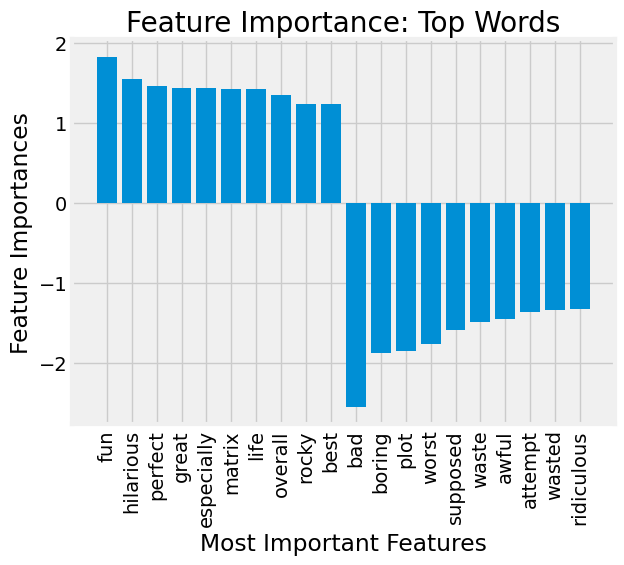

In [48]:
plt.figure(figsize=(7,5), dpi=100)
plt.style.use('fivethirtyeight')
#print(plt.style.available)
plt.bar(x = feature_importance_df['FEATURE'], height=feature_importance_df['IMPORTANCE'])
plt.xlabel("Most Important Features")
plt.ylabel("Feature Importances")
plt.xticks(rotation=90)
plt.title("Feature Importance: Top Words", color="black")

In [49]:
## try a whole new self-created review:)
new_review =['This book looks so like the content but the cover is weird',
             'This book looks not good like the content and the cover is weird',
             "This movie's characters are funny",
            ]
#new_review_bow = tfidf_vec.transform(new_review)
#model_svm.predict(new_review_bow)

pipeline.predict_proba(new_review)

array([[0.63485159, 0.36514841],
       [0.51836718, 0.48163282],
       [0.87972499, 0.12027501]])

# Permutation Importances
* Permutation feature importance is a model inspection technique that can be applied to any fitted classifier using feature-based ML.
* Permutation importance is defined as the decrease in a model score when a single feature value is randomly shuffled.
  * The drop in the model score is indicative of how much the model depends on the feature.
  * The increase in the model score is indicative of how redundant the feature is.
* Permutation importance reports the importance of the feature as the difference between target model accuracy - shuffled model accuracy.
  * Positive permutation importance score, Higher importance.
  * Negative permutation importance score, Lower importance.
* See sklearn documentation: 4.2 Permutation feature importance

In [50]:
%%time
from sklearn.inspection import permutation_importance
r = permutation_importance(model_lg, X_test_bow.toarray(), y_test,
                           n_repeats=5,
                           random_state=0, n_jobs=-1)


CPU times: user 6.54 s, sys: 732 ms, total: 7.27 s
Wall time: 3min 18s


In [51]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

harry   0.006 +/- 0.001
hour    0.006 +/- 0.001
joke    0.005 +/- 0.001
performance0.004 +/- 0.002
watching0.003 +/- 0.000
reeves  0.003 +/- 0.000
stupid  0.003 +/- 0.001
excellent0.003 +/- 0.001
sit     0.003 +/- 0.001
jokes   0.003 +/- 0.001
head    0.003 +/- 0.001
henry   0.002 +/- 0.001
half    0.002 +/- 0.001
awful   0.002 +/- 0.001
lee     0.002 +/- 0.001
october 0.002 +/- 0.001
franklin0.002 +/- 0.001
surprises0.002 +/- 0.001
finally 0.002 +/- 0.001
appeal  0.002 +/- 0.001
wanted  0.002 +/- 0.001
aided   0.002 +/- 0.001
warrior 0.002 +/- 0.001
look    0.002 +/- 0.001
faced   0.002 +/- 0.001
setup   0.002 +/- 0.001
ready   0.002 +/- 0.001
jungle  0.002 +/- 0.001
offer   0.002 +/- 0.001
begin   0.002 +/- 0.001
naturally0.002 +/- 0.001
odd     0.002 +/- 0.001
coming  0.002 +/- 0.001
truth   0.002 +/- 0.001
fair    0.002 +/- 0.001
dangerous0.002 +/- 0.001
deliver 0.002 +/- 0.001
terrific0.002 +/- 0.001
main    0.002 +/- 0.000
kane    0.002 +/- 0.000
judge   0.002 +/- 0.000
liked   0

# Other Variants
* Some of the online code snippets try to implement the show_most_informative_features() in nltk classifier.
* Here the codes only work with linear classifiers (e.g., Logistic models) in sklearn.


In [52]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [53]:
show_most_informative_features(tfidf_vec, model_lg, n=20)

	-2.4610	bad            		1.5968	life           
	-1.6967	t              		1.2076	great          
	-1.5673	boring         		1.1060	family         
	-1.5260	worst          		1.0990	perfect        
	-1.4979	plot           		1.0907	jackie         
	-1.2505	supposed       		1.0333	war            
	-1.1693	waste          		0.9994	mulan          
	-1.1305	stupid         		0.9807	world          
	-1.1044	movie          		0.9544	best           
	-1.0224	harry          		0.9454	hilarious      
	-1.0090	awful          		0.9185	fun            
	-0.9745	script         		0.8743	especially     
	-0.9716	reason         		0.8638	rocky          
	-0.9515	minute         		0.8607	performance    
	-0.9326	unfortunately  		0.8466	different      
	-0.9321	lame           		0.8403	truman         
	-0.9161	looks          		0.8377	perfectly      
	-0.8865	wasted         		0.8162	true           
	-0.8856	poor           		0.8116	overall        
	-0.8778	ridiculous     		0.8107	beautiful      


*For tree-based classifiers, visualization is better.*

In [54]:
import sklearn
from sklearn.tree import plot_tree
text_representation = sklearn.tree.export_text(model_dec)
print(text_representation)

|--- feature_391 <= 0.02
|   |--- feature_562 <= 0.03
|   |   |--- feature_5811 <= 0.04
|   |   |   |--- feature_5694 <= 0.04
|   |   |   |   |--- feature_2939 <= 0.04
|   |   |   |   |   |--- feature_5409 <= 0.02
|   |   |   |   |   |   |--- feature_1969 <= 0.03
|   |   |   |   |   |   |   |--- feature_5693 <= 0.03
|   |   |   |   |   |   |   |   |--- feature_3793 <= 0.02
|   |   |   |   |   |   |   |   |   |--- feature_3894 <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |   |   |--- feature_3894 >  0.03
|   |   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |   |   |--- feature_3793 >  0.02
|   |   |   |   |   |   |   |   |   |--- feature_117 <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- class: pos
|   |   |   |   |   |   |   |   |   |--- feature_117 >  0.03
|   |   |   |   |   |   |   |   |   |   |--- class: neg
|   |   |   |   |   |   |   |--- feature_5693 >  0.03
|   |   |   |   |   |   |   |   |--- featu

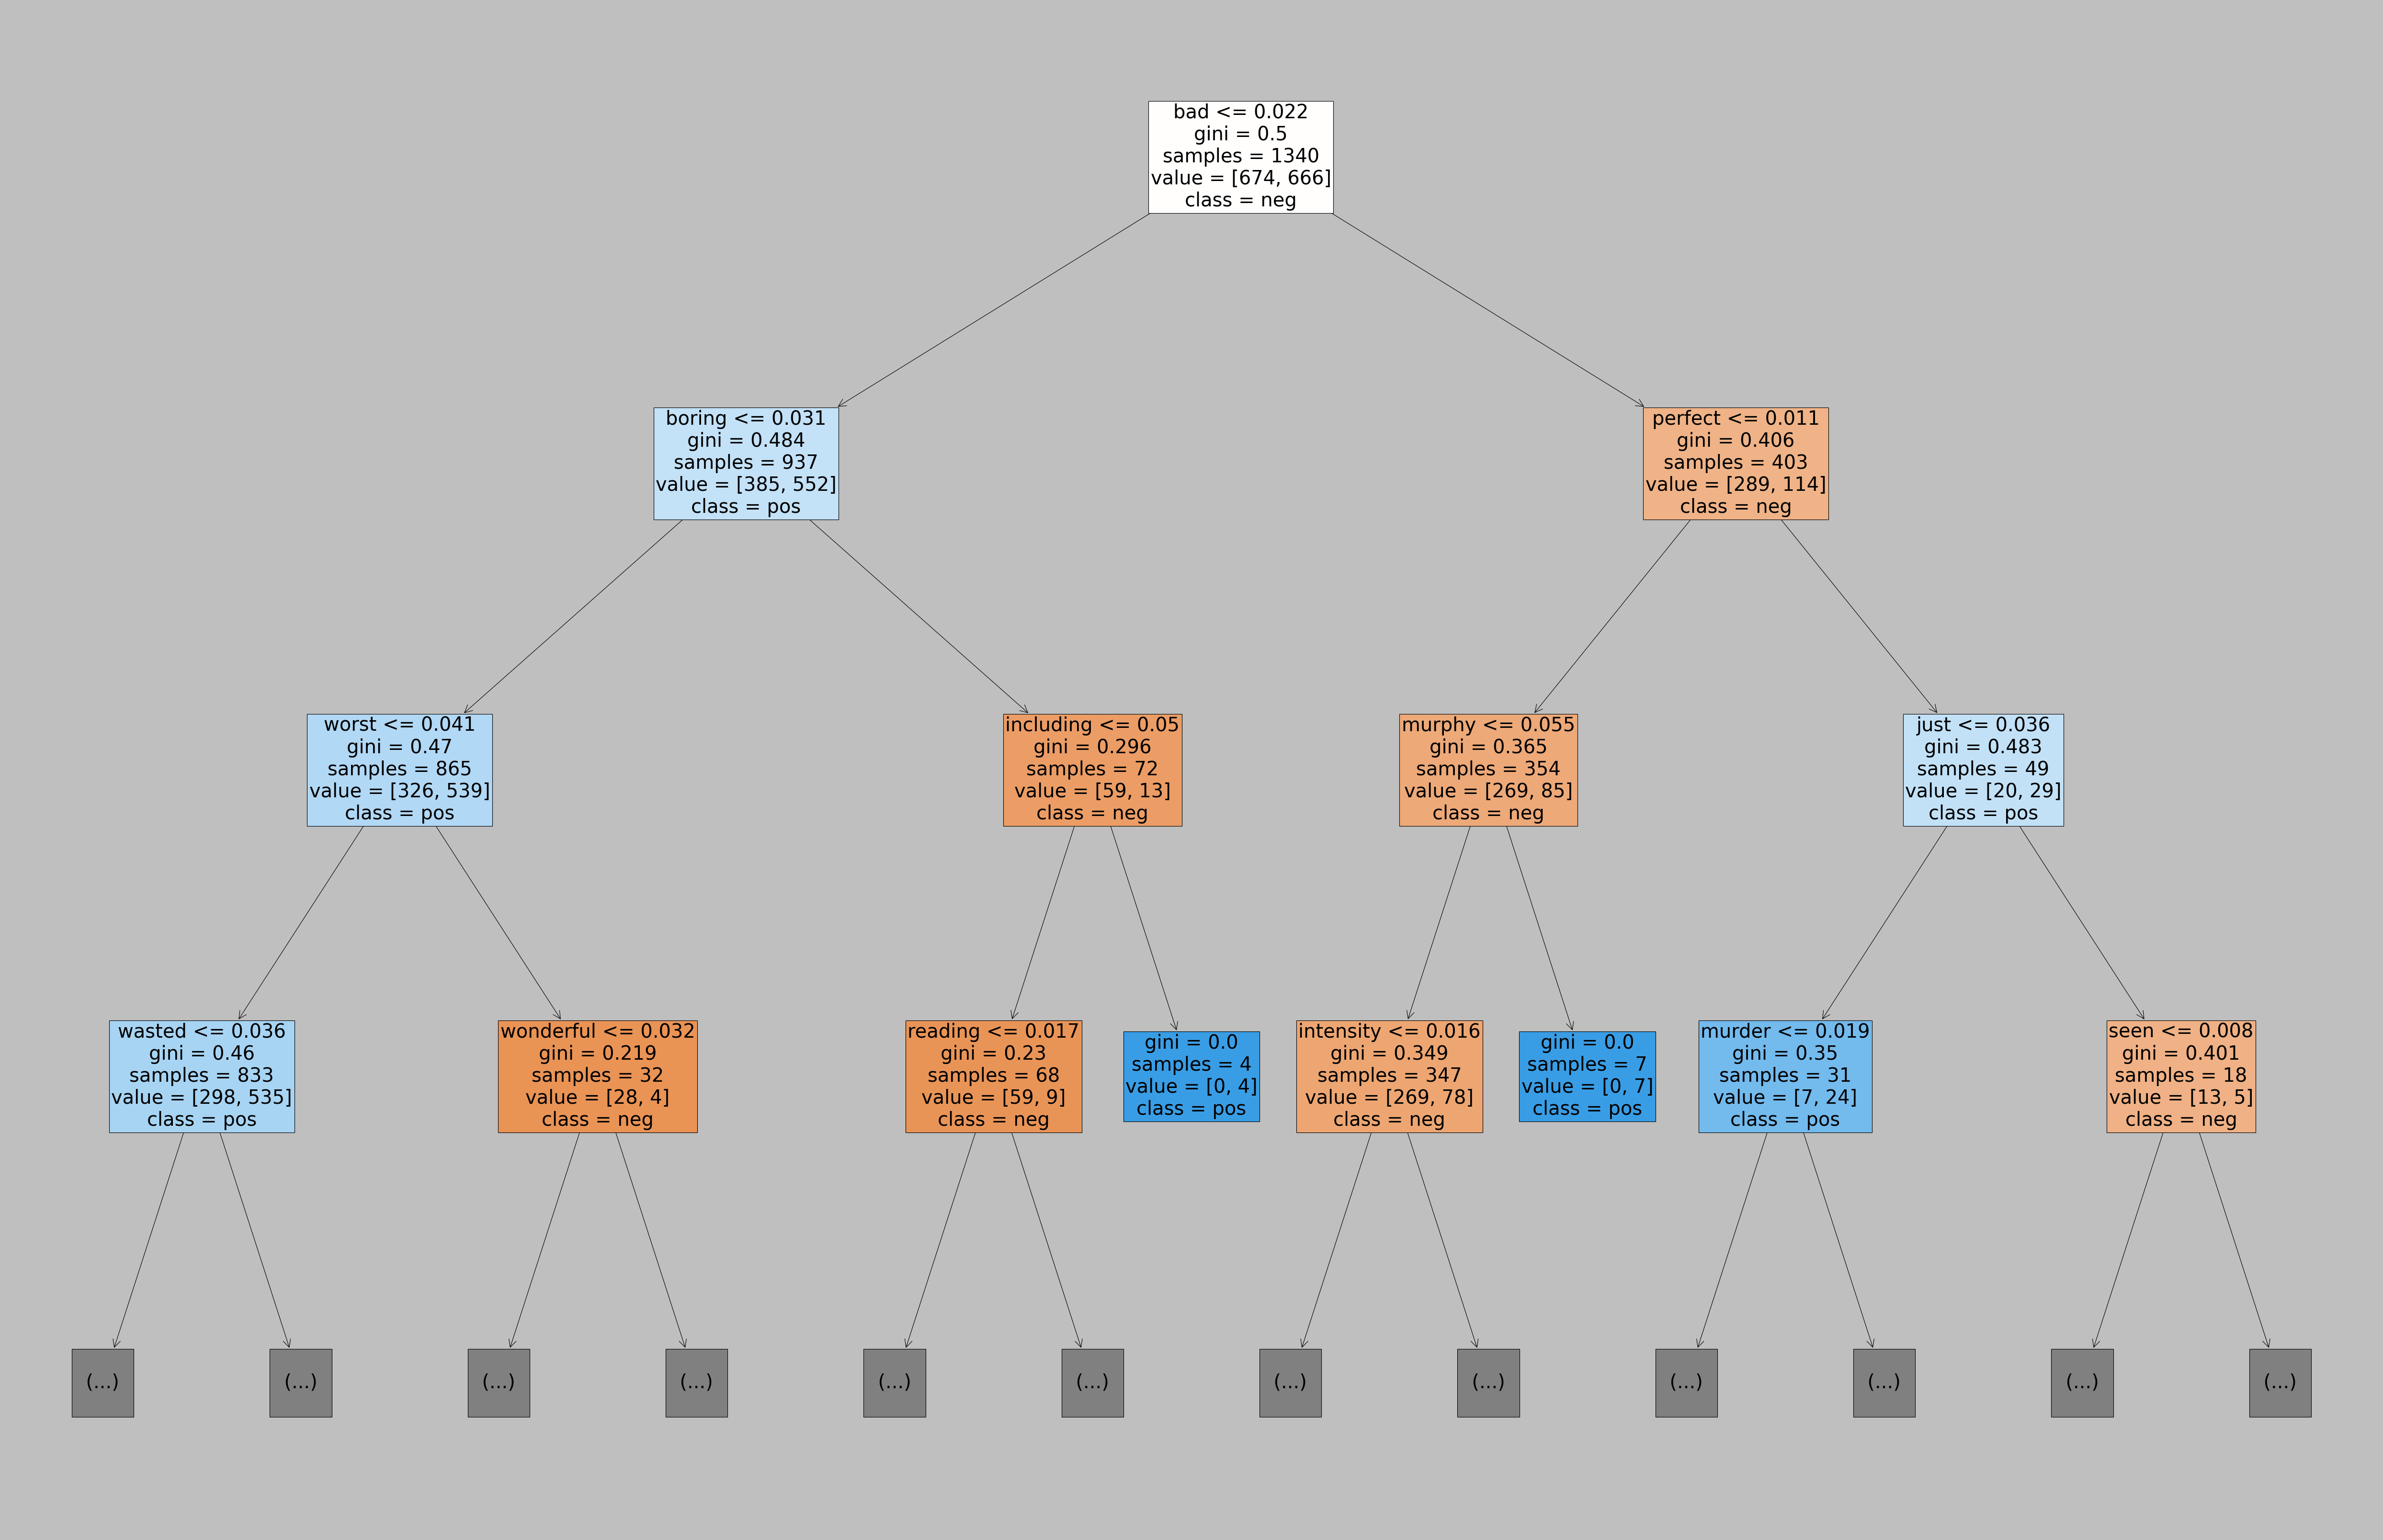

In [55]:
plt.style.use('classic')
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(80,50))
_ = sklearn.tree.plot_tree(model_dec, max_depth=3,
                   feature_names=tfidf_vec.get_feature_names_out().tolist(),  ## parameter requires list
                   class_names=model_dec.classes_.tolist(), ## parameter requires list
                   filled=True, fontsize=36)

#fig.savefig("decistion_tree.png")

#Saving Model

In [56]:
#  import pickle

# with open('../ml-sent-svm.pkl', 'wb') as f:
#     pickle.dump(clf, f)
# with open('../ml-sent-svm.pkl' 'rb') as f:
#     loaded_svm = pickle.load(f)

# ***Dictionary-based Sentiment Classifier***
### * Without machine learning, we can still build a sentiment classifier using a dictionary-based approach.
### * Words can be manually annotated with sentiment polarity scores.
### * Based on the sentiment dictionary, we can then compute the sentiment scores for a text.

# *Disadvantage of Dictionary-based Approach*

* Constructing the sentiment dictionary is time-consuming.
* The sentiment dictionary can be topic-dependent.

# TextBlob Lexicon

In [57]:
from textblob import TextBlob

In [58]:
doc_sent = TextBlob(X_train[0])
print(doc_sent.sentiment)
print(doc_sent.sentiment.polarity)

Sentiment(polarity=0.15877050157184083, subjectivity=0.5661635487528345)
0.15877050157184083


In [59]:
doc_sents = [TextBlob(doc).sentiment.polarity for doc in X_train]

In [60]:
y_train[:10]

['neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'pos', 'neg', 'pos']

In [61]:
doc_sents_prediction = ['pos' if score >= 0.1 else 'neg' for score in doc_sents]
doc_sents_prediction[:10]

['pos', 'neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg']

In [62]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
print(accuracy_score(y_train, doc_sents_prediction))
print(f1_score(y_train, doc_sents_prediction, average=None, labels=['neg','pos']))

0.7425373134328358
[0.74872542 0.73603673]


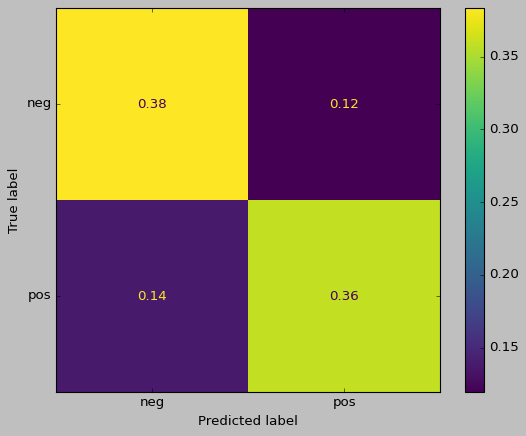

In [63]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_prediction, normalize="all"), display_labels=['neg','pos']).plot()

## AFINN Lexicon

In [64]:
!pip install afinn
from afinn import Afinn

In [65]:
afn = Afinn(emoticons=True)

afn.score("This movie, not good. worth it :( But can give it a try!! worth it")

0.0

In [66]:
doc_sents_afn = [afn.score(d) for d in X_train]
doc_sents_afn_prediction = ['pos' if score >= 1.0 else 'neg' for score in doc_sents_afn]
print(accuracy_score(y_train, doc_sents_afn_prediction))
print(f1_score(y_train, doc_sents_afn_prediction, average=None, labels=['neg','pos']))

0.6686567164179105
[0.61458333 0.70942408]


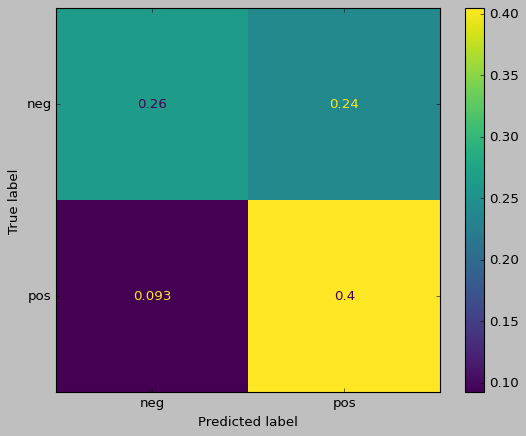

In [67]:
ConfusionMatrixDisplay(confusion_matrix(y_train, doc_sents_afn_prediction, normalize="all"),display_labels=['neg','pos']).plot()